# OCR Expiry Date and Production Code Detection with EasyOCR

Name: Anthony Kevin Oktavius

In [1]:
! pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 22.3 MB/s eta 0:00:00


In [2]:
! pip install opencv-python-headless

Download Fonts

In [3]:
! wget https://github.com/jondot/dotfiles/raw/master/.fonts/calibri.ttf

--2023-11-06 14:15:39--  https://github.com/jondot/dotfiles/raw/master/.fonts/calibri.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jondot/dotfiles/master/.fonts/calibri.ttf [following]
--2023-11-06 14:15:39--  https://raw.githubusercontent.com/jondot/dotfiles/master/.fonts/calibri.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352736 (344K) [application/octet-stream]
Saving to: ‘calibri.ttf’

calibri.ttf         100%[===================>] 344.47K  --.-KB/s    in 0.02s   

2023-11-06 14:15:39 (14.4 MB/s) - ‘calibri.ttf’ saved [352736/352736]



In [1]:
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image, ImageFilter, ImageOps, ImageEnhance
from easyocr import Reader
from datetime import datetime

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import string

Set the languages that we'd like to work with.

In [2]:
languages_list = ['en']

Make the process faster by using GPU.

In [3]:
gpu = True

## Data Preparation

In [7]:
! unzip -qq /content/drive/MyDrive/Dataset/Test-OCR.zip

List all of the files for testing.

In [4]:
TEST_OCR_DIR = "Test-OCR"

date_real_paths = list(os.listdir(TEST_OCR_DIR))
print(date_real_paths)

['Image_20231103153842005.bmp', 'Image_20231103154009502.bmp', 'Image_20231103154207260.bmp', 'Image_20231103154101029.bmp', 'Image_20231103153515942.bmp', 'Image_20231103153428429.bmp', 'Image_20231103153733509.bmp', 'Image_20231103153630624.bmp', 'Image_20231103154043801.bmp', 'Image_20231103153649469.bmp']


## Data Preprocessing

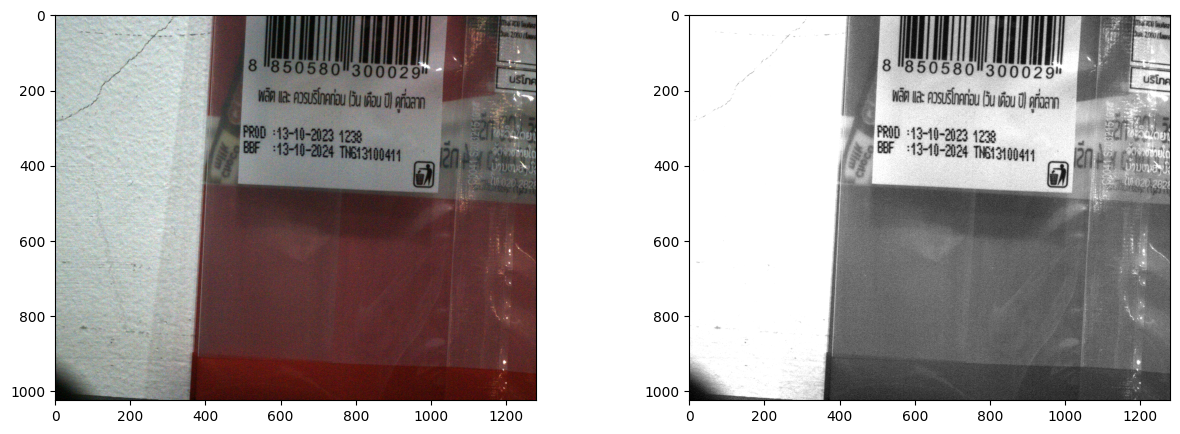

In [5]:
%matplotlib inline

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Increase brightness
    BRIGHTNESS_FACTOR = 1.7
    image = cv2.convertScaleAbs(image, alpha=BRIGHTNESS_FACTOR, beta=0)

    return np.array(image)

example_image_path = f"{TEST_OCR_DIR}/{date_real_paths[0]}"

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
image = Image.open(example_image_path)
image = np.array(image)
plt.imshow(image)

plt.subplot(1, 2, 2)
image = preprocess_image(example_image_path)
plt.imshow(image, cmap = "gray")

plt.show()

## Data Modelling

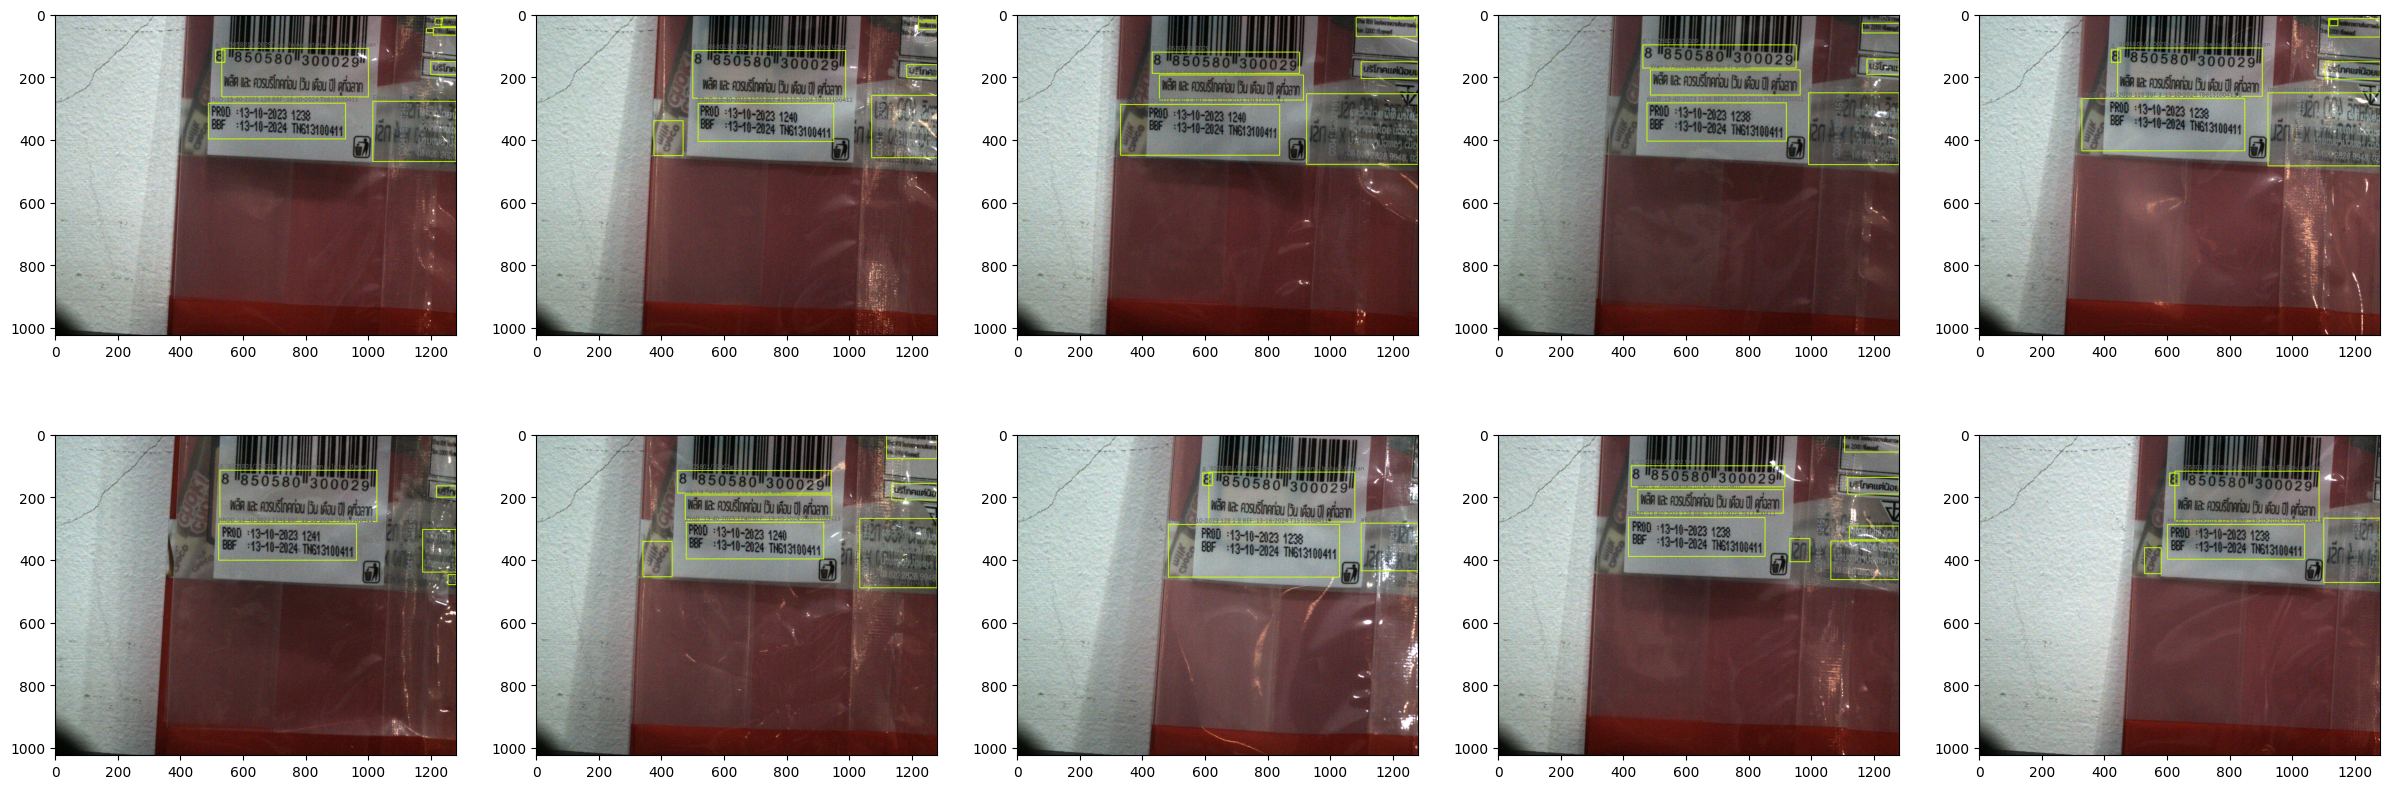

In [6]:
%matplotlib inline

def get_image(path):
  image = Image.open(path)
  return image

def write_text(text, x, y, image, font, color = (100, 100, 100), font_size = 22):
  font = ImageFont.truetype(font, font_size)
  image_pil = Image.fromarray(image)
  draw = ImageDraw.Draw(image_pil)
  draw.text((x, y - font_size), text, font = font, fill = color)
  image = np.array(image_pil)
  return image

def get_box_coordinates(bounding_box):
  (left_top, right_top, bottom_right, bottom_left) = bounding_box
  left_top = (int(left_top[0]), int(left_top[1]))
  right_top = (int(right_top[0]), int(right_top[1]))
  bottom_right = (int(bottom_right[0]), int(bottom_right[1]))
  bottom_left = (int(bottom_left[0]), int(bottom_left[1]))
  return left_top, right_top, bottom_right, bottom_left

def draw_ocr_box_on_img(image, left_top, bottom_right, color = (200, 255, 0), thickness = 2):
  cv2.rectangle(image, left_top, bottom_right, color, thickness)
  return image

font = '/content/calibri.ttf'

N_ROWS = 2
N_COLS = 5
THRESHOLD = 0.1

images_border_informations = []
reader = Reader(languages_list, gpu)

plt.figure(figsize = (30, 10))
for path_index, path in enumerate(date_real_paths):
  image = get_image(f"{TEST_OCR_DIR}/{path}")
  preprocessed_image = preprocess_image(f"{TEST_OCR_DIR}/{path}")

  results = reader.readtext(
      np.array(preprocessed_image),
      paragraph = True,
      x_ths = 0.2,
      y_ths = 0.06,
  )

  image = np.array(image)

  bboxes = []
  texts = []

  for (box, text) in results:
    left_top, right_top, bottom_right, bottom_left = get_box_coordinates(box)

    image = draw_ocr_box_on_img(
      image, left_top = left_top, bottom_right = bottom_right,
    )

    image = write_text(text, left_top[0], left_top[1], image, font)

    bboxes.append([left_top, right_top, bottom_right, bottom_left])
    texts.append(text)

  image_border_information = {
      "bboxes": bboxes,
      "texts": texts,
  }

  images_border_informations.append(image_border_information)

  plt.subplot(N_ROWS, N_COLS, path_index + 1)
  plt.imshow(image)

plt.show()

Save the border informations with pickle

In [7]:
image_border_informations_path = "drive/MyDrive/Models/ocr_image_border_informations.pickle"

In [8]:
import pickle
pickle.dump(images_border_informations, open(image_border_informations_path, "wb"))

In [9]:
image_border_informations = pickle.load(open(image_border_informations_path, "rb"))
image_border_informations

[{'bboxes': [[(1213, 15), (1237, 15), (1237, 33), (1213, 33)],
   [(1185, 45), (1207, 45), (1207, 59), (1185, 59)],
   [(1207, 43), (1280, 43), (1280, 67), (1207, 67)],
   [(512, 114), (542, 114), (542, 154), (512, 154)],
   [(532, 109), (1000, 109), (1000, 264), (532, 264)],
   [(1199, 151), (1280, 151), (1280, 193), (1199, 193)],
   [(489, 284), (927, 284), (927, 398), (489, 398)],
   [(1014, 278), (1280, 278), (1280, 470), (1014, 470)],
   [(1232, 12), (1281, 12), (1281, 40), (1232, 40)]],
  'texts': ['0',
   'Ut',
   '20 Hlatt',
   '8',
   '"8 505801300029" wan Ie Aosustanau Liu 6ou d| qioan',
   'usina',
   'ERoD :13-40-2023 128 BBF :13-10-2024 T1613100411',
   'Epuavoui F2n Aomolot Uouuaue {Uor0_828',
   '@an']},
 {'bboxes': [[(1221, 1), (1277, 1), (1277, 19), (1221, 19)],
   [(500, 116), (988, 116), (988, 268), (500, 268)],
   [(1183, 161), (1280, 161), (1280, 203), (1183, 203)],
   [(517, 285), (950, 285), (950, 406), (517, 406)],
   [(1071, 259), (1284, 259), (1284, 458), (107

## Post Preprocessing

Define function to extract the information from production code and expire date only.

The code logic:

* Find all date texts from the all bounding boxes.
* Re-recognize the date text, but only from selected bounding boxes.
* Fix text from the given bounding box.
* Done!

In [10]:
def get_cleaned_punctuation_characters(text):
  strings_to_be_deleted = string.punctuation
  strings_to_be_deleted = strings_to_be_deleted \
    .replace("-", "") \
    .replace(":", "")
  text = text.translate(str.maketrans('', '', strings_to_be_deleted))
  return text

def is_expiry_date_and_production_code(text):
  expiry_date_and_production_code_regex = r'\S+\s*:?\s*\d{2}-\d{2}-\d{4}\s+\S+'
  is_match = re.findall(expiry_date_and_production_code_regex, text)
  return is_match

valid_bboxes = []

for path_index, bbox_info_item in enumerate(image_border_informations):
  bboxes = bbox_info_item['bboxes']
  texts = bbox_info_item['texts']
  for bbox, text in zip(bboxes, texts):
    text = get_cleaned_punctuation_characters(text)
    if is_expiry_date_and_production_code(text):
      valid_bboxes.append({
          "bbox": bbox,
          "text": text,
      })
      break

valid_bboxes

[{'bbox': [(489, 284), (927, 284), (927, 398), (489, 398)],
  'text': 'ERoD :13-40-2023 128 BBF :13-10-2024 T1613100411'},
 {'bbox': [(517, 285), (950, 285), (950, 406), (517, 406)],
  'text': 'FRpD :13-40-2023 1240 BEF 413-10-2024 T0613100411'},
 {'bbox': [(330, 288), (838, 288), (838, 450), (330, 450)],
  'text': 'ERoD :13-10-2023 1240 1 BBF 1 13-10-2024 TN513100411'},
 {'bbox': [(475, 283), (920, 283), (920, 405), (475, 405)],
  'text': 'RroD :13-40-2023 1238 BEF 413-10-8024 TNG13100411'},
 {'bbox': [(328, 269), (848, 269), (848, 436), (328, 436)],
  'text': 'PRoD :13-10-2028 128 BBF 3 13-10-2024 T8613100411 8'},
 {'bbox': [(522, 286), (962, 286), (962, 402), (522, 402)],
  'text': 'RROD :13-40-2023 1241 BBF 13-10-2024 78613100411'},
 {'bbox': [(479, 281), (918, 281), (918, 398), (479, 398)],
  'text': 'ProD :13-40-2023 1240 BEF :13-10-2024 7N613100411'},
 {'bbox': [(483, 288), (1029, 288), (1029, 456), (483, 456)],
  'text': 'ERoD :13-10-2023 128 1 8 BEF :13-16-2024 T1513100411'},


Get only the relevant cropped part of the post-processed bounding box. Then, perform second post-processing, after we have cropped the image.

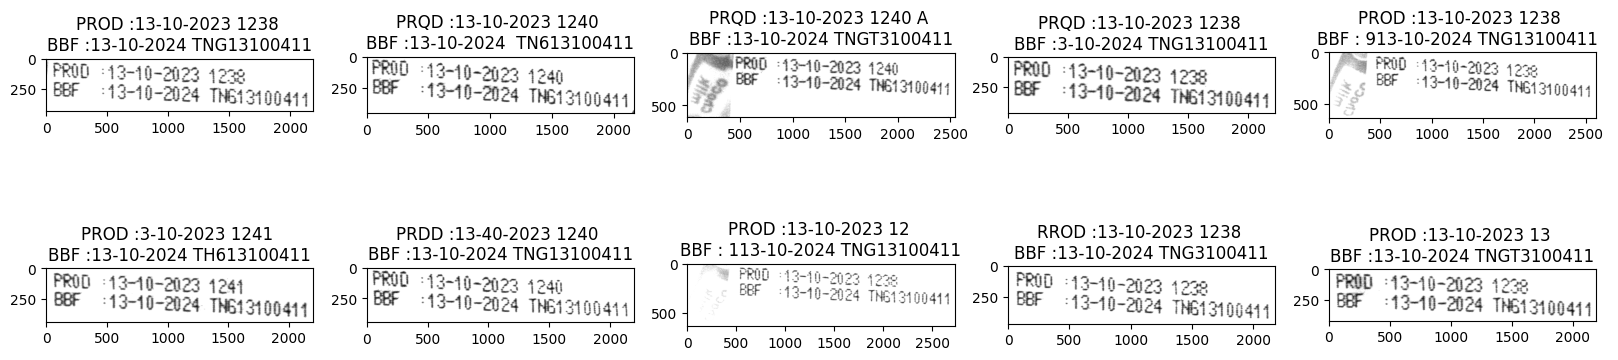

In [224]:
def crop_image(image, left_top, bottom_right):
  x_min, y_min = left_top
  x_max, y_max = bottom_right

  cropped_image = image[y_min:y_max, x_min:x_max]
  return cropped_image

from scipy import ndimage

def postprocess_cropped_image(image):
  BRIGHTNESS_FACTOR = 1.4
  kernel = np.ones((3, 3), np.uint8)

  # image = cv2.resize(image, (0, 0), fx = 4, fy = 2.8)
  # image = cv2.convertScaleAbs(image, alpha=BRIGHTNESS_FACTOR, beta=0)
  # image = ndimage.rotate(image, 1)
  image = cv2.resize(image, (0, 0), fx = 5, fy = 3.8)
  image = cv2.convertScaleAbs(image, alpha=BRIGHTNESS_FACTOR, beta=0)
  image = cv2.dilate(image, kernel, iterations = 2)
  return np.array(image)

def preprocess_text_from_cropped_image(text):
  # Remove noise (singular character) from the image.
  preprocessed_text = re.sub(r'\b[0123456789]\b', " ", text)

  # Add a space after "BBF"
  preprocessed_text = re.sub(r'BBF', '\nBBF', preprocessed_text)

  # Add a colon after the first word of each line
  preprocessed_text = re.sub(r'^(\w+)', r'\1 :', preprocessed_text, flags=re.MULTILINE)

  preprocessed_text = re.sub(r': .', ':', preprocessed_text)

  return preprocessed_text

N_ROWS = 2
N_COLS = 5

%matplotlib inline

plt.figure(figsize = (20, 5))
for path_index, path in enumerate(date_real_paths):
  image = get_image(f"{TEST_OCR_DIR}/{path}")
  preprocessed_image = preprocess_image(f"{TEST_OCR_DIR}/{path}")
  left_top, _, bottom_right, _ = valid_bboxes[path_index]["bbox"]
  cropped_image = crop_image(preprocessed_image, left_top, bottom_right)
  cropped_image = postprocess_cropped_image(cropped_image)

  ignore_punctuations = string.punctuation \
    .replace("-", "") \

  bboxes_post_info = reader.readtext(
      cropped_image,
      paragraph = True,
      x_ths = 5,
      y_ths = 1,
      blocklist = ignore_punctuations,
      decoder = "wordbeamsearch",
      rotation_info = [0, 5, -5, 10, -10]
  )

  _, text = bboxes_post_info[0]

  text = preprocess_text_from_cropped_image(text)

  plt.subplot(N_ROWS, N_COLS, path_index + 1)
  plt.title(text)
  plt.imshow(cropped_image, cmap = "gray")

plt.show()